In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = 0.    
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
             
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss
   
   

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [17]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [18]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [19]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.955864 32: 0.948106 64: 0.956732
Train Epoch: 1 [12800/50000 (26%)]	Losses 16: 0.507571 32: 0.419571 64: 0.359906
Train Epoch: 1 [25600/50000 (51%)]	Losses 16: 0.326881 32: 0.307132 64: 0.295482
Train Epoch: 1 [38400/50000 (77%)]	Losses 16: 0.290416 32: 0.282486 64: 0.276205
Train Epoch: 1 [12512/50000 (100%)]	Losses 16: 0.243384 32: 0.237555 64: 0.233156
Test set:
16: loss: 0.2813	pho_loss: 0.0032
32: loss: 0.2770	pho_loss: 0.0033
64: loss: 0.2730	pho_loss: 0.0033

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.292312 32: 0.288262 64: 0.284145
Train Epoch: 2 [12800/50000 (26%)]	Losses 16: 0.283725 32: 0.280914 64: 0.278339
Train Epoch: 2 [25600/50000 (51%)]	Losses 16: 0.270020 32: 0.267240 64: 0.266165
Train Epoch: 2 [38400/50000 (77%)]	Losses 16: 0.270357 32: 0.266777 64: 0.267367
Train Epoch: 2 [12512/50000 (100%)]	Losses 16: 0.230018 32: 0.225207 64: 0.229105
Test set:
16: loss: 0.2616	pho_loss: 0.0031
32: loss: 0.2581	pho_loss: 0.0031
64: los

Train Epoch: 17 [12800/50000 (26%)]	Losses 16: 0.135853 32: 0.117434 64: 0.109805
Train Epoch: 17 [25600/50000 (51%)]	Losses 16: 0.137364 32: 0.116892 64: 0.111352
Train Epoch: 17 [38400/50000 (77%)]	Losses 16: 0.147314 32: 0.125167 64: 0.117112
Train Epoch: 17 [12512/50000 (100%)]	Losses 16: 0.162652 32: 0.139450 64: 0.131290
Test set:
16: loss: 0.1419	pho_loss: 0.0032
32: loss: 0.1199	pho_loss: 0.0032
64: loss: 0.1128	pho_loss: 0.0031

Train Epoch: 18 [0/50000 (0%)]	Losses 16: 0.140161 32: 0.119108 64: 0.112689
Train Epoch: 18 [12800/50000 (26%)]	Losses 16: 0.146971 32: 0.123730 64: 0.116544
Train Epoch: 18 [25600/50000 (51%)]	Losses 16: 0.132891 32: 0.111794 64: 0.105958
Train Epoch: 18 [38400/50000 (77%)]	Losses 16: 0.126605 32: 0.105735 64: 0.099215
Train Epoch: 18 [12512/50000 (100%)]	Losses 16: 0.118234 32: 0.098515 64: 0.096589
Test set:
16: loss: 0.1371	pho_loss: 0.0032
32: loss: 0.1159	pho_loss: 0.0032
64: loss: 0.1078	pho_loss: 0.0031

Train Epoch: 19 [0/50000 (0%)]	Losses 1

In [20]:
torch.save(models['64'], './model_64_kl_gn1')


/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [6]:
model = torch.load('./model_64_kl_gn1')

In [7]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([  7,   6,   3,   7,   5,   5,   2,   4,   3,   4,   5,   0,
          6,   6,   5,   3,   5,   4,   6,   3,   9,   8,   2,   4,
          3,   4,   8,   4,   6,   6,   4,   6,   8,   1,   5,   3,
          3,   5,   1,   6,   5,   4,   4,   1,   3,   4,   6,   3,
          5,   4,   4,   2,   5,   4,   3,   5,   4,   3,   6,   5,
         11,   1,   1,   2])


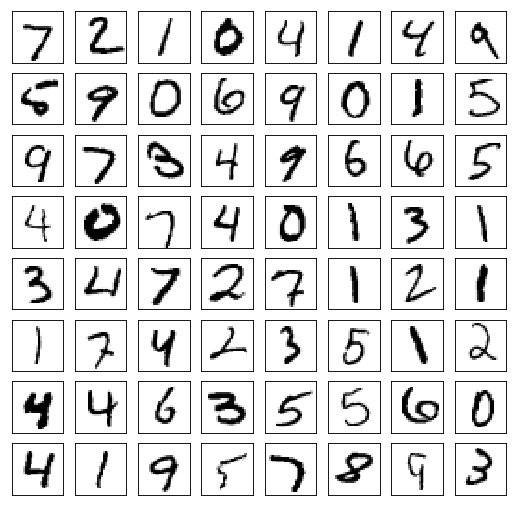

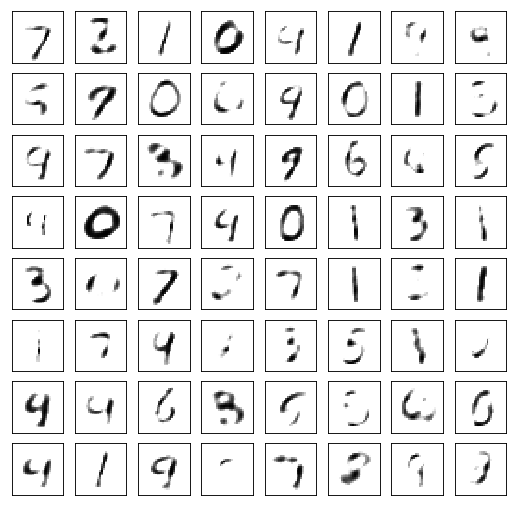

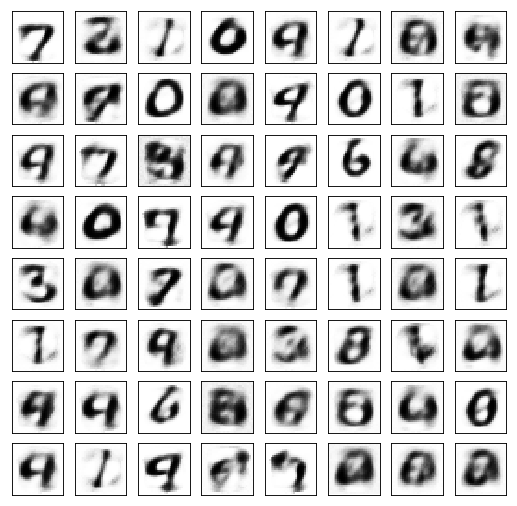

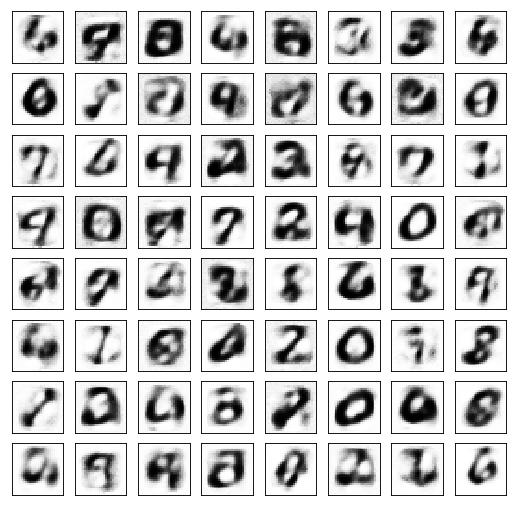

In [8]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

### Генерация новых изображений


In [291]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(64)
    loss_stats = []
    
    gen_optim = optim.Adam([gen_img_par], lr=1e-4, weight_decay=0.)

    for i in range(1, 500001):  

        
        target = model.E(gen_img_par.view(-1, 28*28))

        
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        #gen_img_par.backward(loss)        
        loss.backward()
        gen_optim.step()
        
        if i % 1000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 5:    
                if ls > loss_stats[-2] and ls > loss_stats[-3]:
                    print ("Loss is rising .. stop")
                    break

        if i % 5000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (8, 8))
                        
    return gen_img_par    

### Генерация изображения из батча

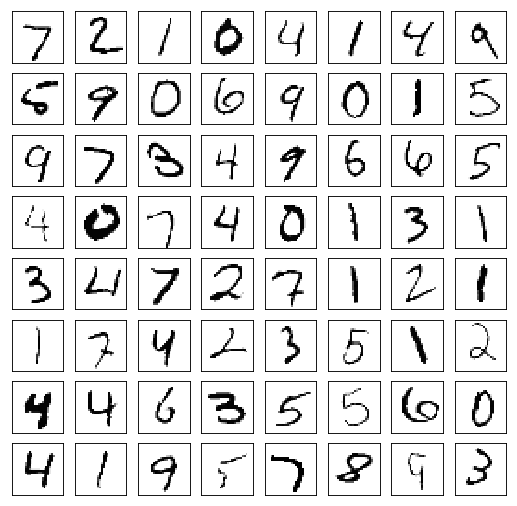

In [292]:
img, _ = next(iter(test_loader))
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 1000: loss=0.018174072727560997
Iteration 2000: loss=0.0144511042162776
Iteration 3000: loss=0.011822691187262535
Iteration 4000: loss=0.009402234107255936
Iteration 5000: loss=0.007074784487485886


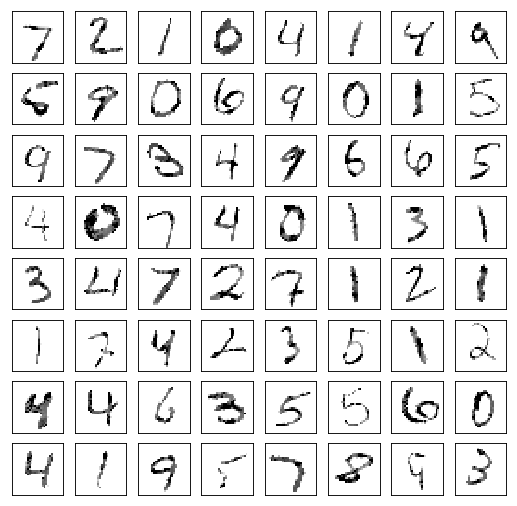

Iteration 6000: loss=0.005223971325904131
Iteration 7000: loss=0.004066602326929569
Iteration 8000: loss=0.003251279704272747
Iteration 9000: loss=0.002729464555159211
Iteration 10000: loss=0.002387259854003787


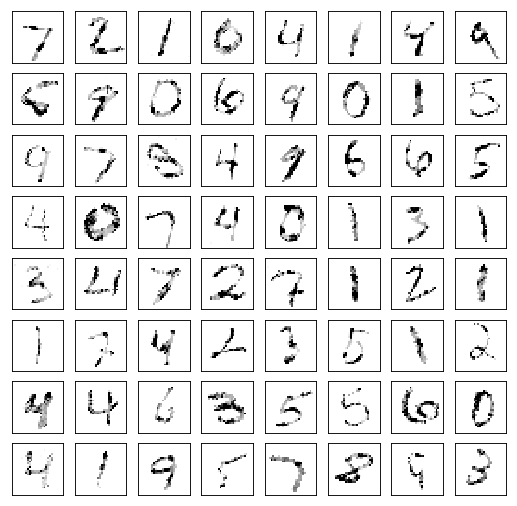

Iteration 11000: loss=0.00211059651337564
Iteration 12000: loss=0.0017901231767609715
Iteration 13000: loss=0.001611813553608954
Iteration 14000: loss=0.0014833863824605942
Iteration 15000: loss=0.0013808229705318809


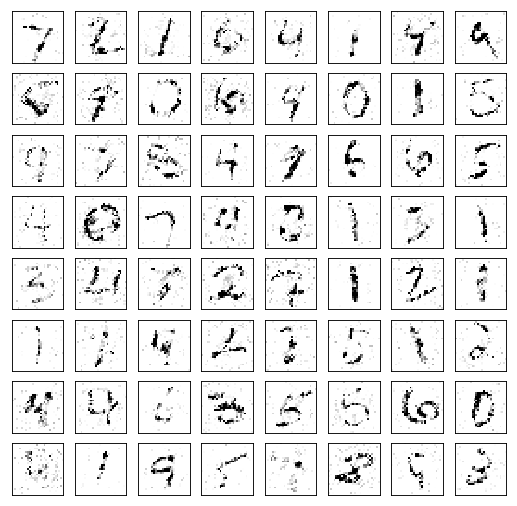

Iteration 16000: loss=0.0012966474751010537
Iteration 17000: loss=0.0012274590553715825
Iteration 18000: loss=0.0011729149846360087
Iteration 19000: loss=0.0011286565568298101
Iteration 20000: loss=0.0010925369570031762


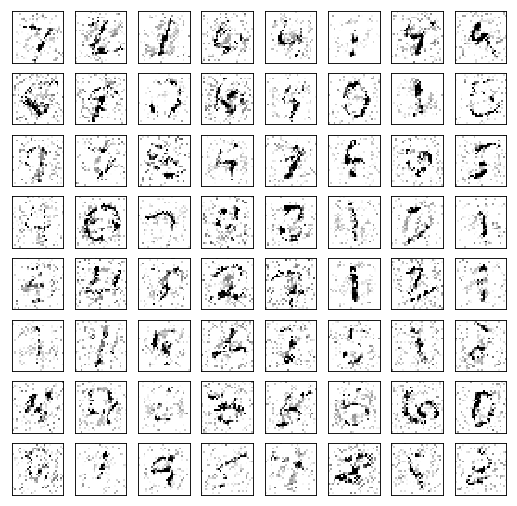

Iteration 21000: loss=0.0010632816702127457
Iteration 22000: loss=0.001038579037413001
Iteration 23000: loss=0.0010170440655201674
Iteration 24000: loss=0.0009998506866395473
Iteration 25000: loss=0.000985248014330864


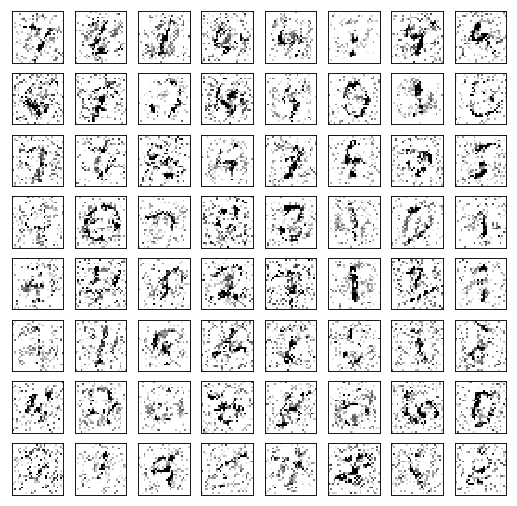

Iteration 26000: loss=0.0009718749206513166
Iteration 27000: loss=0.0009593036375008523
Iteration 28000: loss=0.00094958784757182
Iteration 29000: loss=0.0009416344109922647
Iteration 30000: loss=0.0009339887765236199


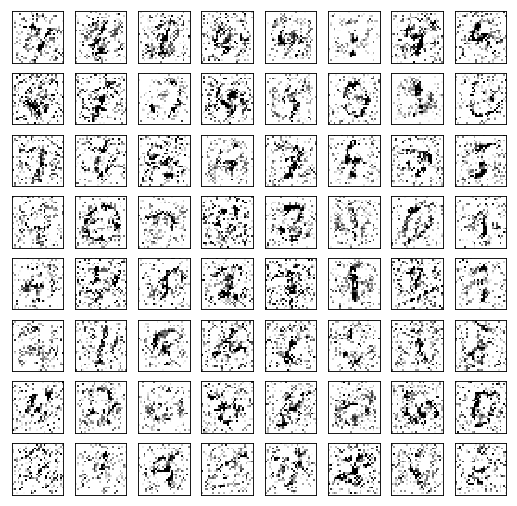

Iteration 31000: loss=0.0009264680556952953
Iteration 32000: loss=0.0009202532237395644
Iteration 33000: loss=0.0009147512027993798
Iteration 34000: loss=0.0009101931354962289
Iteration 35000: loss=0.0009062742465175688


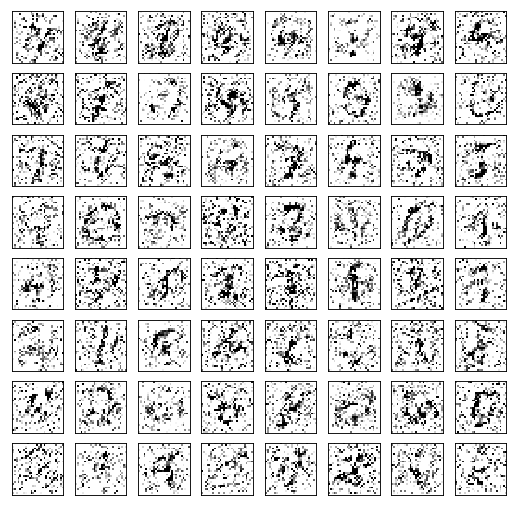

Iteration 36000: loss=0.0009027633932419121
Iteration 37000: loss=0.0008991382201202214
Iteration 38000: loss=0.0008958366233855486
Iteration 39000: loss=0.0008926969021558762
Iteration 40000: loss=0.000889912131242454


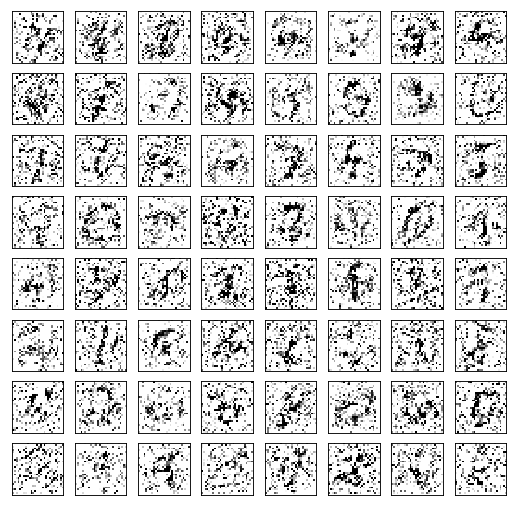

Iteration 41000: loss=0.0008876819629222155
Iteration 42000: loss=0.0008856934146024287
Iteration 43000: loss=0.0008839474176056683
Iteration 44000: loss=0.0008824505493976176
Iteration 45000: loss=0.000881111016497016


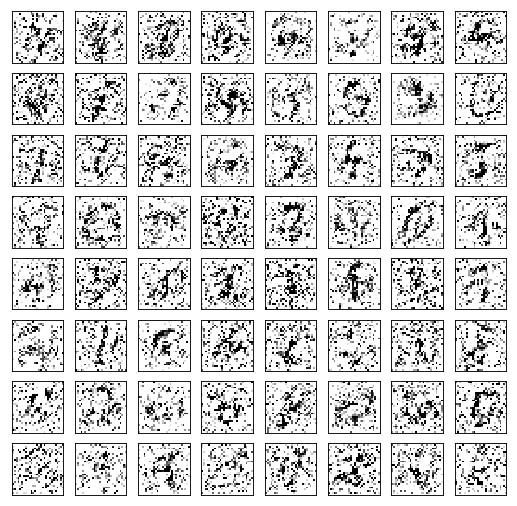

Iteration 46000: loss=0.0008798316703177989
Iteration 47000: loss=0.0008784778765402734
Iteration 48000: loss=0.0008768892730586231
Iteration 49000: loss=0.0008752657449804246
Iteration 50000: loss=0.0008735632873140275


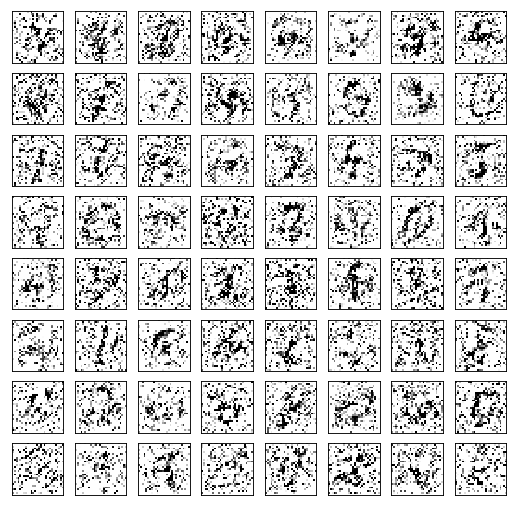

Iteration 51000: loss=0.0008722204947844148
Iteration 52000: loss=0.0008711129194125533
Iteration 53000: loss=0.0008701164042577147
Iteration 54000: loss=0.0008688604575581849
Iteration 55000: loss=0.0008678340236656368


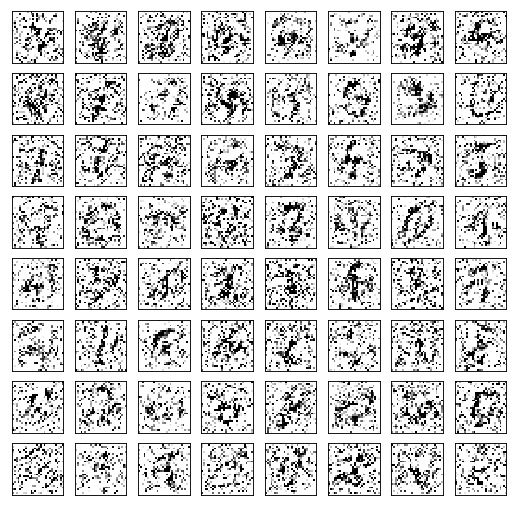

Iteration 56000: loss=0.000867071095854044
Iteration 57000: loss=0.0008663673652336001
Iteration 58000: loss=0.0008656688733026385
Iteration 59000: loss=0.0008650047238916159
Iteration 60000: loss=0.0008644028566777706


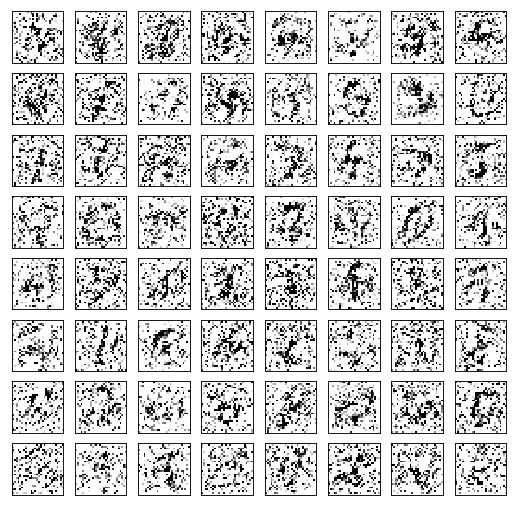

Iteration 61000: loss=0.0008638518629595637
Iteration 62000: loss=0.0008633432444185019
Iteration 63000: loss=0.000862853426951915
Iteration 64000: loss=0.0008623728062957525
Iteration 65000: loss=0.0008618325227871537


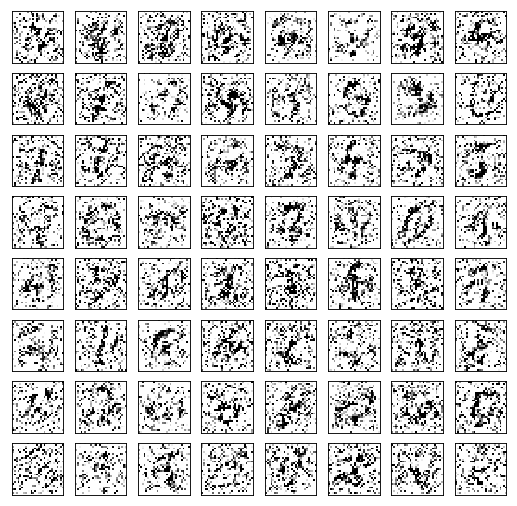

Iteration 66000: loss=0.0008610914810560644
Iteration 67000: loss=0.000860233383718878
Iteration 68000: loss=0.0008592825033701956
Iteration 69000: loss=0.0008585195173509419
Iteration 70000: loss=0.0008578913984820247


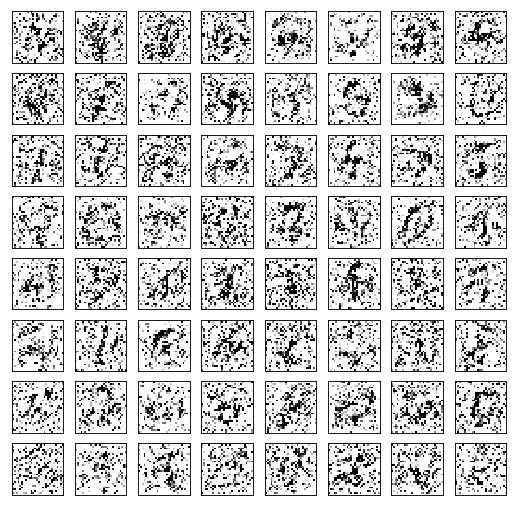

Iteration 71000: loss=0.000857346982229501
Iteration 72000: loss=0.0008568541961722076
Iteration 73000: loss=0.0008563749142922461
Iteration 74000: loss=0.0008558097761124372
Iteration 75000: loss=0.0008550499915145338


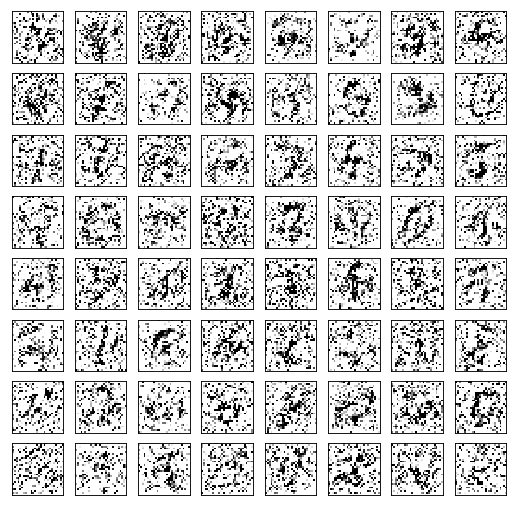

Iteration 76000: loss=0.0008542694849893451
Iteration 77000: loss=0.0008534169755876064
Iteration 78000: loss=0.0008527452009730041
Iteration 79000: loss=0.0008521010749973357
Iteration 80000: loss=0.0008516398956999183


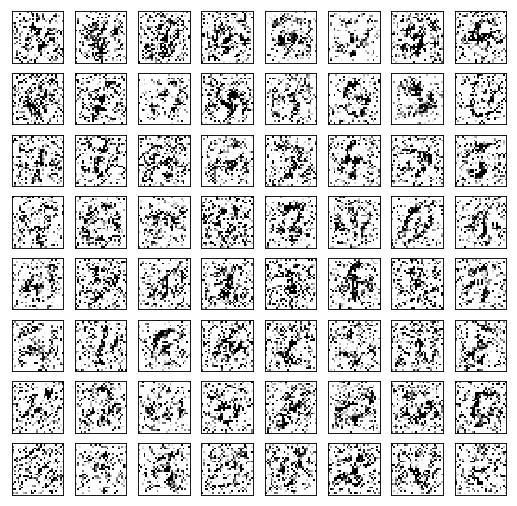

Iteration 81000: loss=0.0008513123611919582
Iteration 82000: loss=0.0008510439074598253
Iteration 83000: loss=0.0008508107275702059
Iteration 84000: loss=0.0008505977457389235
Iteration 85000: loss=0.0008503998978994787


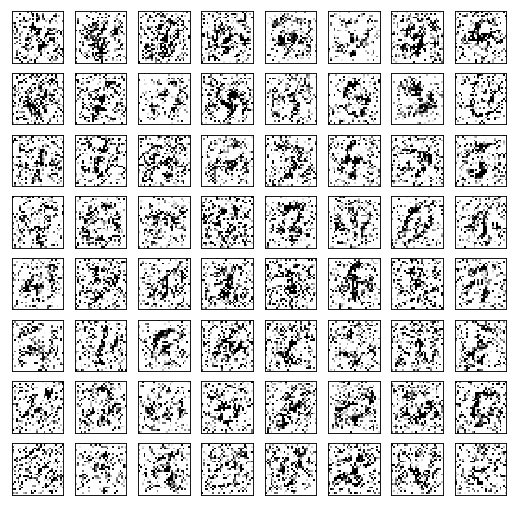

Iteration 86000: loss=0.0008502036798745394
Iteration 87000: loss=0.0008500083931721747
Iteration 88000: loss=0.0008498019888065755
Iteration 89000: loss=0.0008495876681990921
Iteration 90000: loss=0.0008493729401379824


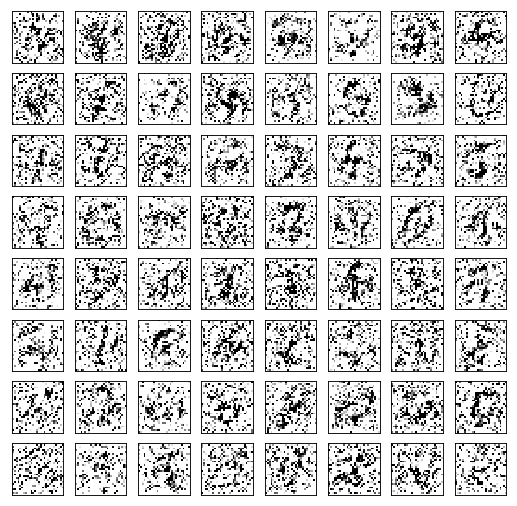

Iteration 91000: loss=0.0008491436019539833
Iteration 92000: loss=0.0008489342289976776
Iteration 93000: loss=0.0008487609447911382
Iteration 94000: loss=0.000848609721288085
Iteration 95000: loss=0.0008484728168696165


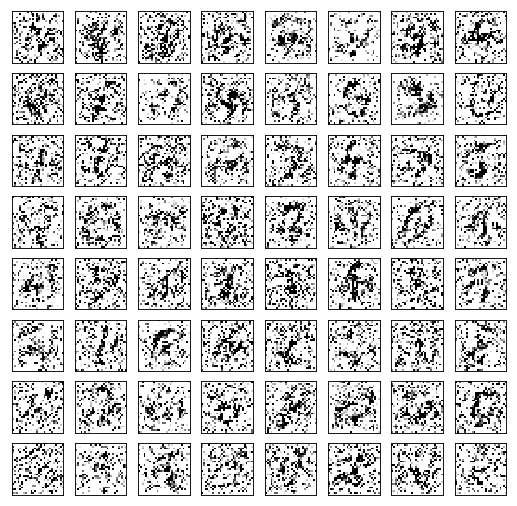

Iteration 96000: loss=0.0008483457495458424
Iteration 97000: loss=0.0008482260745950043
Iteration 98000: loss=0.0008481143158860505
Iteration 99000: loss=0.0008480065735056996
Iteration 100000: loss=0.0008479043026454747


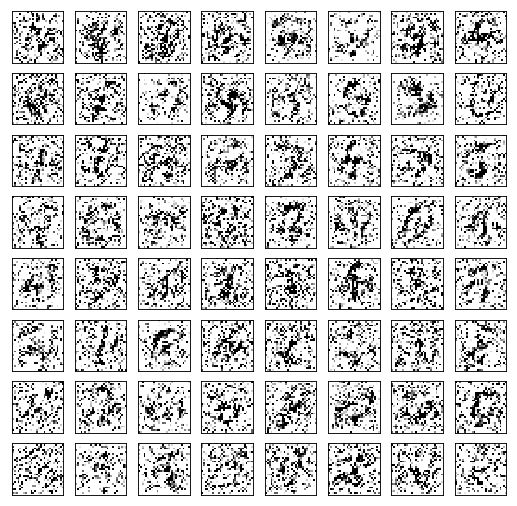

Iteration 101000: loss=0.0008478042436763644
Iteration 102000: loss=0.0008477076189592481
Iteration 103000: loss=0.0008476124494336545
Iteration 104000: loss=0.0008475157665088773
Iteration 105000: loss=0.0008474124479107559


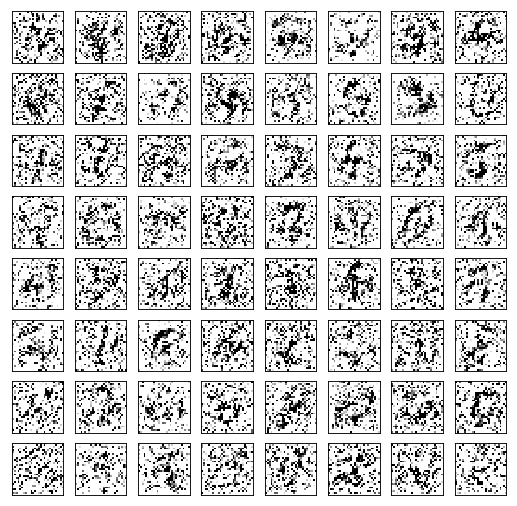

Iteration 106000: loss=0.0008472956251353025
Iteration 107000: loss=0.0008471758337691426
Iteration 108000: loss=0.0008470645407214761
Iteration 109000: loss=0.000846948241814971
Iteration 110000: loss=0.0008468100568279624


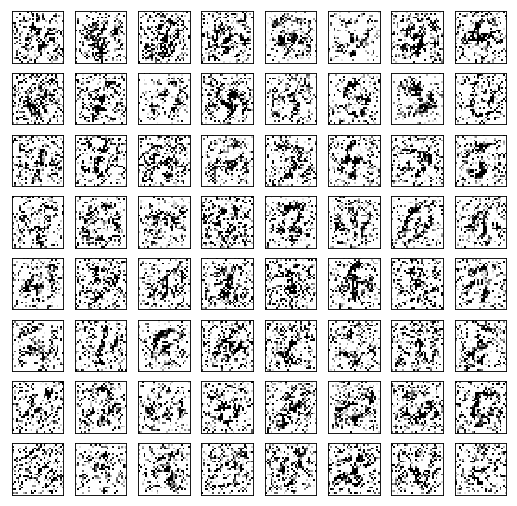

Iteration 111000: loss=0.000846654293127358
Iteration 112000: loss=0.0008463817648589611
Iteration 113000: loss=0.0008450839668512344
Iteration 114000: loss=0.0008444014238193631
Iteration 115000: loss=0.0008441782556474209


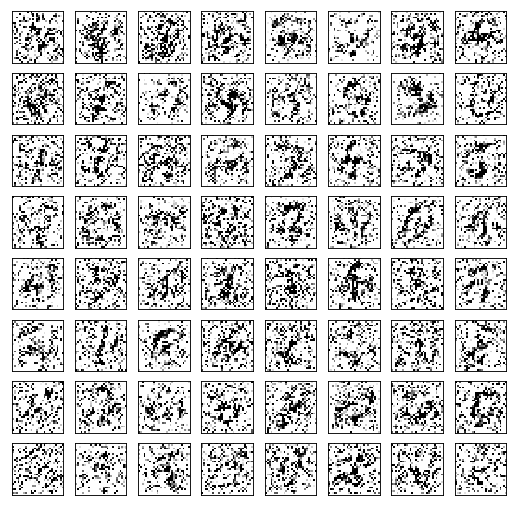

Iteration 116000: loss=0.0008440302917733788
Iteration 117000: loss=0.0008438892546109855
Iteration 118000: loss=0.000843703921418637
Iteration 119000: loss=0.0008435032214038074
Iteration 120000: loss=0.0008433633483946323


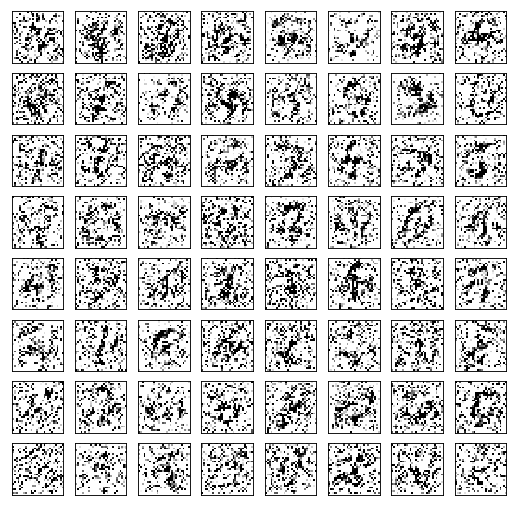

Iteration 121000: loss=0.000843257934320718
Iteration 122000: loss=0.0008431633468717337
Iteration 123000: loss=0.0008430719026364386
Iteration 124000: loss=0.000842964684125036
Iteration 125000: loss=0.0008427826105616987


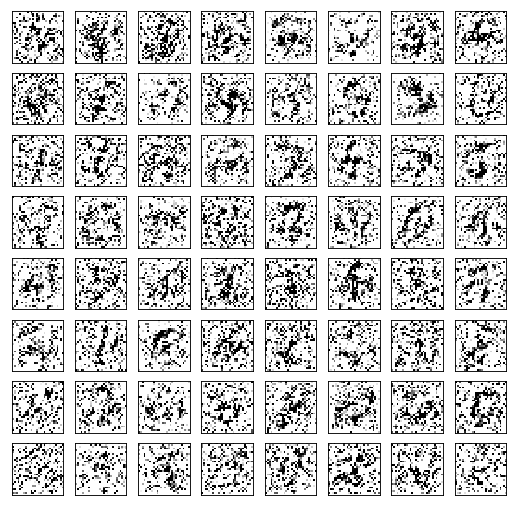

Iteration 126000: loss=0.0008425374398939312
Iteration 127000: loss=0.0008423685212619603
Iteration 128000: loss=0.0008422579267062247
Iteration 129000: loss=0.0008421727106906474
Iteration 130000: loss=0.0008421028032898903


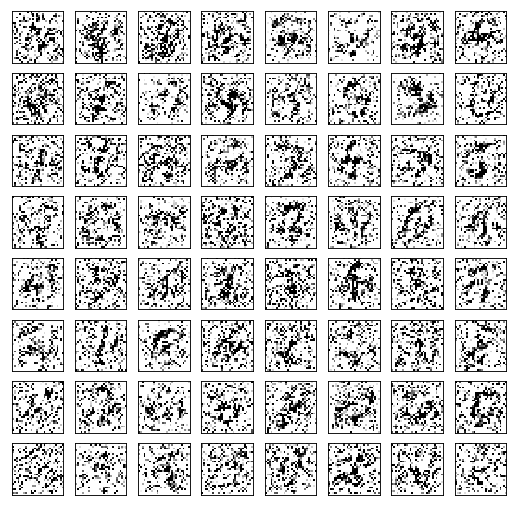

Iteration 131000: loss=0.0008420356898568571
Iteration 132000: loss=0.0008419735822826624
Iteration 133000: loss=0.0008419128716923296
Iteration 134000: loss=0.0008418530924245715
Iteration 135000: loss=0.0008417933131568134


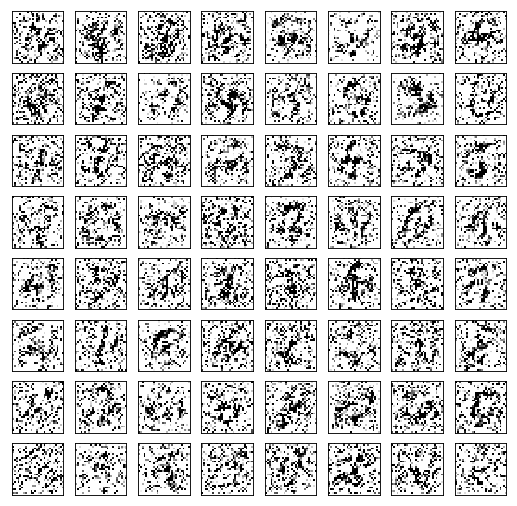

Iteration 136000: loss=0.0008417367935180664
Iteration 137000: loss=0.0008416820783168077
Iteration 138000: loss=0.00084162806160748
Iteration 139000: loss=0.0008415756747126579
Iteration 140000: loss=0.0008415228221565485


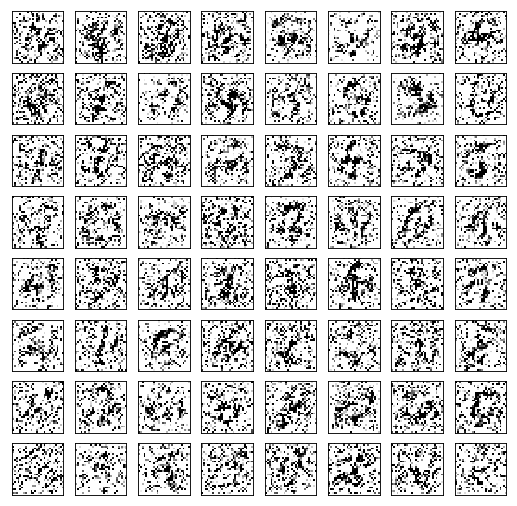

Iteration 141000: loss=0.0008414684562012553
Iteration 142000: loss=0.0008414117619395256
Iteration 143000: loss=0.0008413520408794284
Iteration 144000: loss=0.0008412902825511992
Iteration 145000: loss=0.0008412257884629071


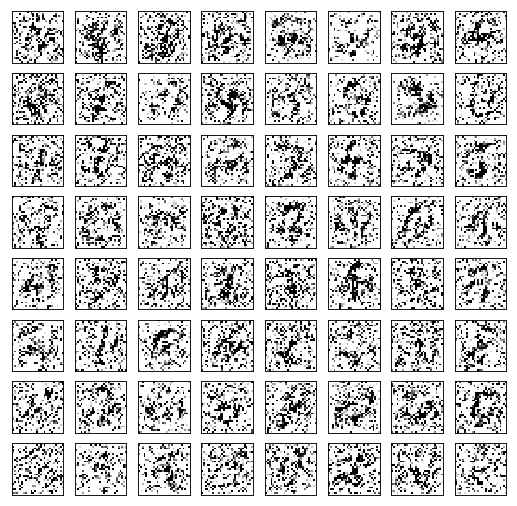

Iteration 146000: loss=0.0008411635062657297
Iteration 147000: loss=0.0008411037852056324
Iteration 148000: loss=0.0008410472655668855
Iteration 149000: loss=0.0008409940637648106
Iteration 150000: loss=0.000840941327624023


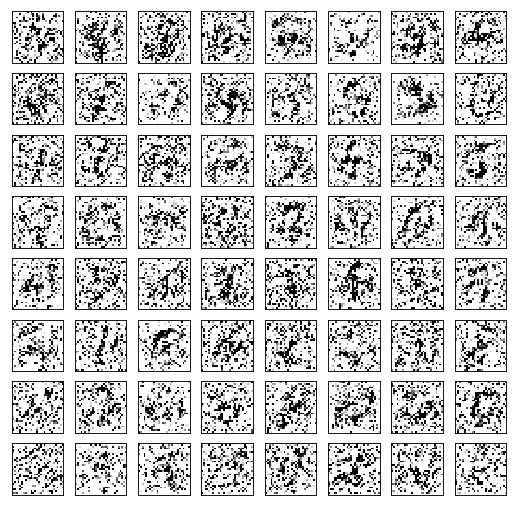

Iteration 151000: loss=0.0008408880094066262
Iteration 152000: loss=0.000840833003167063
Iteration 153000: loss=0.0008407810819335282
Iteration 154000: loss=0.000840727414470166
Iteration 155000: loss=0.0008406741544604301


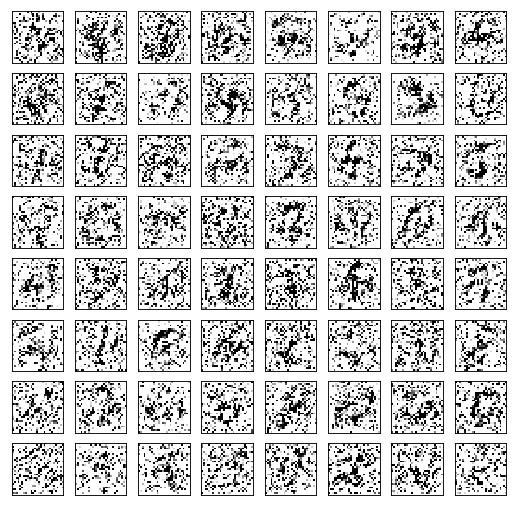

Iteration 156000: loss=0.0008406181586906314
Iteration 157000: loss=0.0008405576227232814
Iteration 158000: loss=0.0008404789841733873
Iteration 159000: loss=0.0008403839310631156
Iteration 160000: loss=0.0008402871899306774


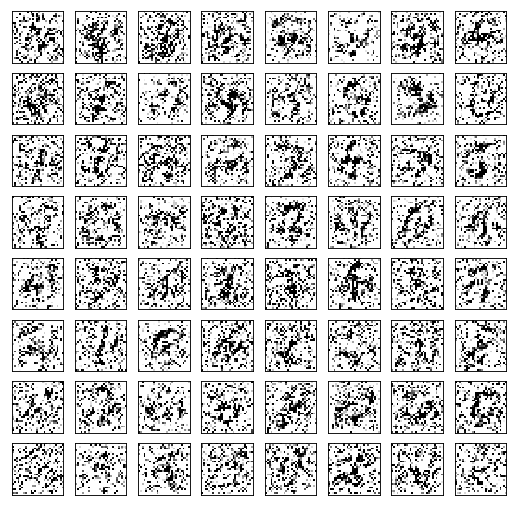

Iteration 161000: loss=0.0008401846862398088
Iteration 162000: loss=0.0008400732185691595
Iteration 163000: loss=0.0008399581420235336
Iteration 164000: loss=0.000839842134155333
Iteration 165000: loss=0.0008397173369303346


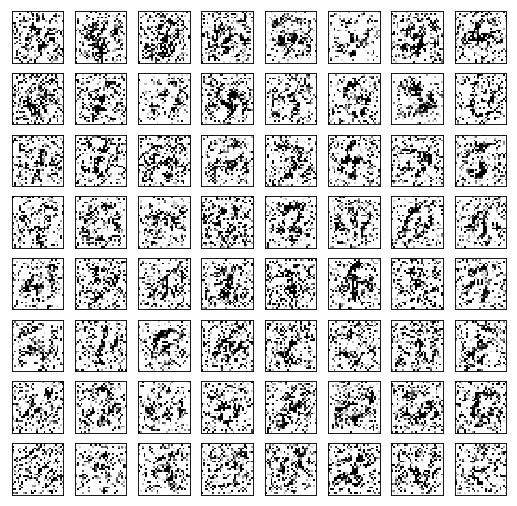

Iteration 166000: loss=0.0008395819459110498
Iteration 167000: loss=0.0008394714095629752
Iteration 168000: loss=0.000839381420519203
Iteration 169000: loss=0.0008393042371608317
Iteration 170000: loss=0.0008392364252358675


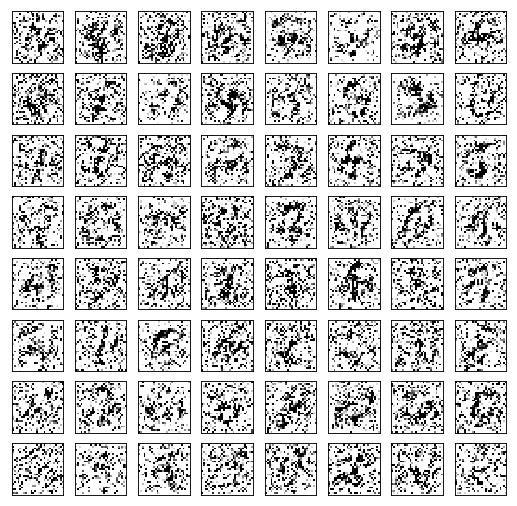

Iteration 171000: loss=0.0008391772280447185
Iteration 172000: loss=0.000839122396428138
Iteration 173000: loss=0.0008390746079385281
Iteration 174000: loss=0.0008390325820073485
Iteration 175000: loss=0.0008389957365579903


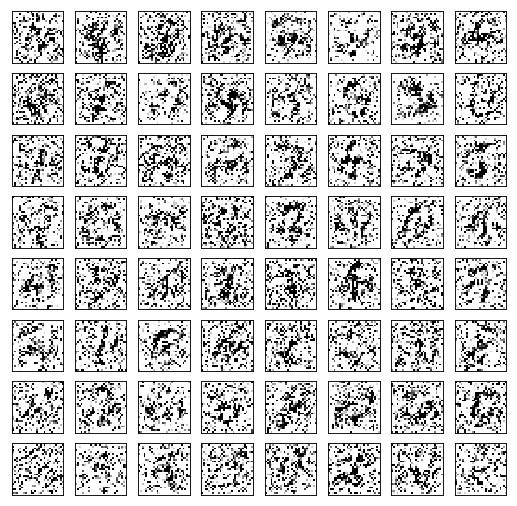

Iteration 176000: loss=0.000838962325360626
Iteration 177000: loss=0.000838932057376951
Iteration 178000: loss=0.0008389020804315805
Iteration 179000: loss=0.000838876178022474
Iteration 180000: loss=0.0008388485293835402


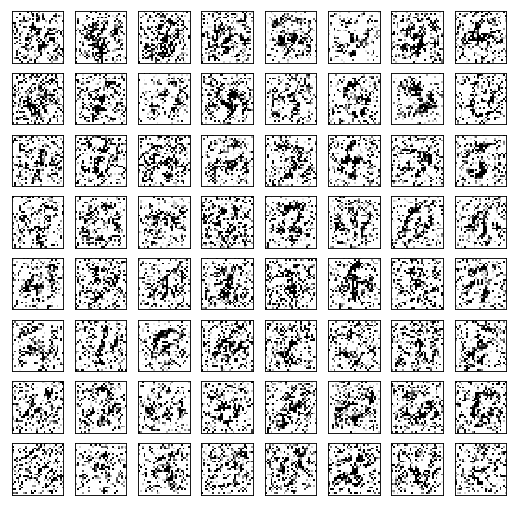

Iteration 181000: loss=0.0008388232672587037
Iteration 182000: loss=0.0008387973648495972
Iteration 183000: loss=0.0008387726848013699
Iteration 184000: loss=0.0008387464331462979
Iteration 185000: loss=0.0008387236157432199


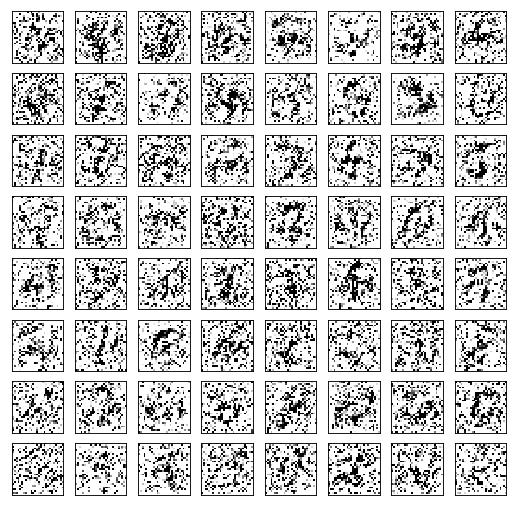

Iteration 186000: loss=0.0008386985282413661
Iteration 187000: loss=0.0008386758854612708
Iteration 188000: loss=0.000838653591927141
Iteration 189000: loss=0.0008386314148083329
Iteration 190000: loss=0.0008386102272197604


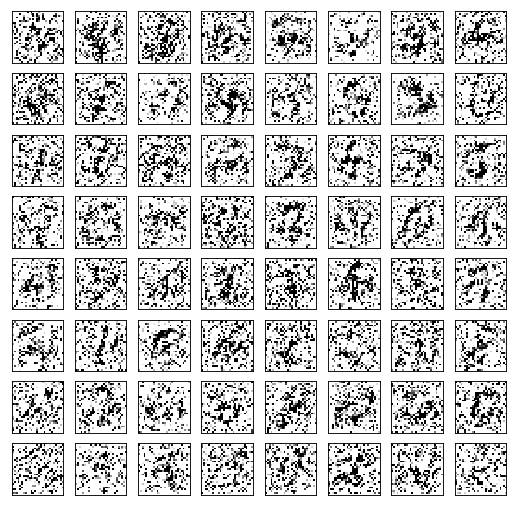

Iteration 191000: loss=0.0008385897963307798
Iteration 192000: loss=0.0008385687251575291
Iteration 193000: loss=0.0008385478286072612
Iteration 194000: loss=0.0008385269902646542
Iteration 195000: loss=0.0008385083056055009


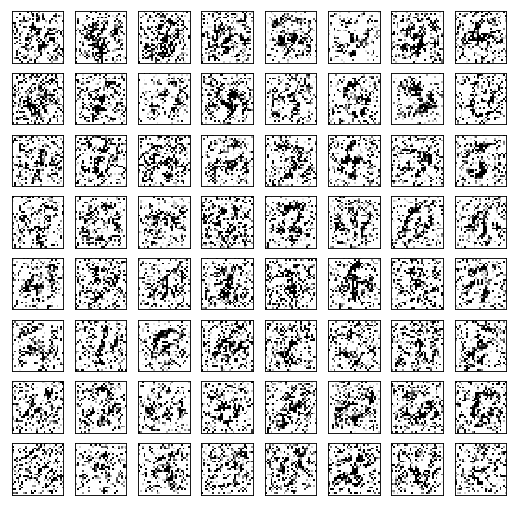

Iteration 196000: loss=0.0008384898537769914
Iteration 197000: loss=0.0008384723914787173
Iteration 198000: loss=0.0008384526008740067
Iteration 199000: loss=0.000838433566968888
Iteration 200000: loss=0.0008384153479710221


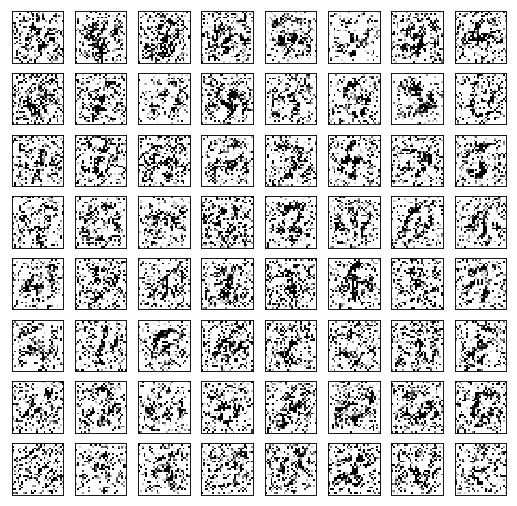

Iteration 201000: loss=0.0008383960812352598
Iteration 202000: loss=0.0008383761160075665
Iteration 203000: loss=0.0008383525419048965
Iteration 204000: loss=0.0008383258827961981
Iteration 205000: loss=0.0008382983505725861


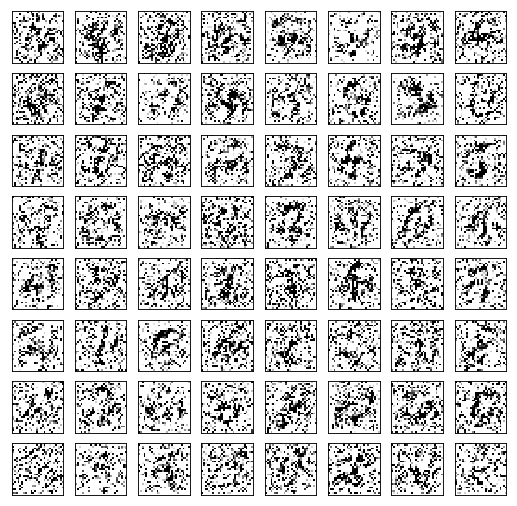

Iteration 206000: loss=0.0008382684900425375
Iteration 207000: loss=0.0008382416563108563
Iteration 208000: loss=0.0008382181986235082
Iteration 209000: loss=0.0008381972438655794
Iteration 210000: loss=0.0008381751831620932


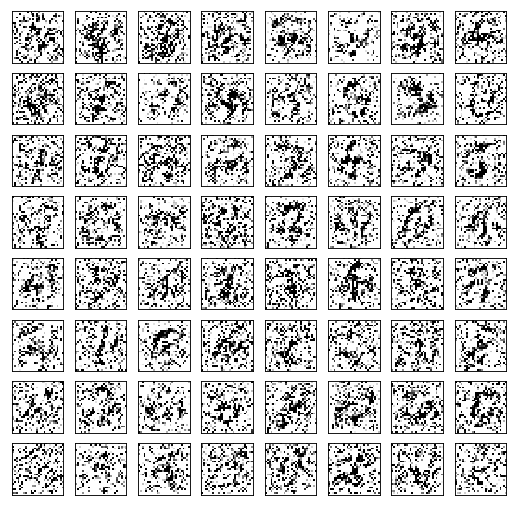

Iteration 211000: loss=0.0008381558582186699
Iteration 212000: loss=0.0008381379302591085
Iteration 213000: loss=0.0008381197694689035
Iteration 214000: loss=0.0008381020743399858
Iteration 215000: loss=0.0008380851941183209


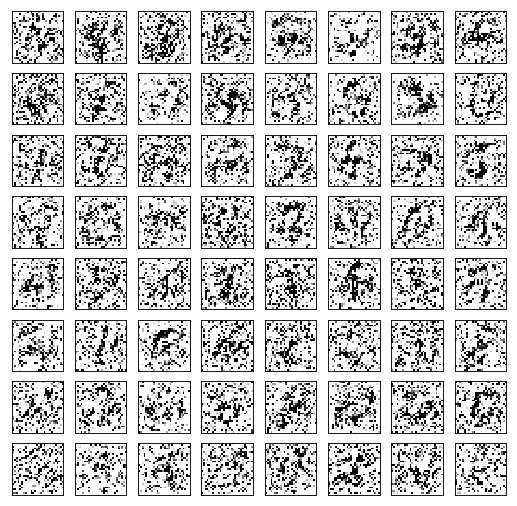

Iteration 216000: loss=0.0008380691870115697
Iteration 217000: loss=0.0008380527142435312
Iteration 218000: loss=0.00083803606685251
Iteration 219000: loss=0.0008380209910683334
Iteration 220000: loss=0.0008380042854696512


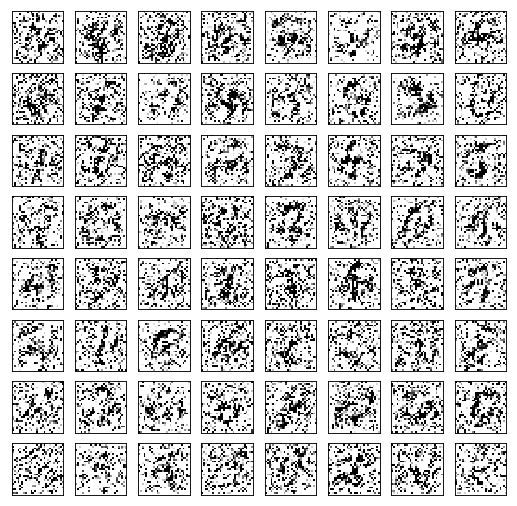

Iteration 221000: loss=0.0008379881619475782
Iteration 222000: loss=0.0008379693608731031
Iteration 223000: loss=0.0008379491046071053
Iteration 224000: loss=0.0008379291975870728
Iteration 225000: loss=0.0008379105711355805


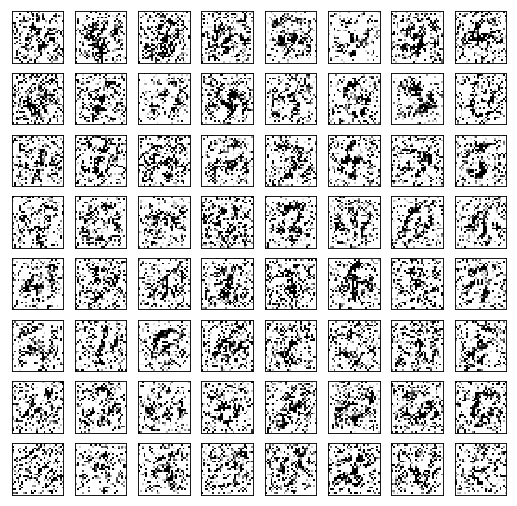

Iteration 226000: loss=0.0008378917700611055
Iteration 227000: loss=0.0008378758793696761
Iteration 228000: loss=0.0008378599304705858
Iteration 229000: loss=0.0008378454949706793
Iteration 230000: loss=0.0008378311758860946


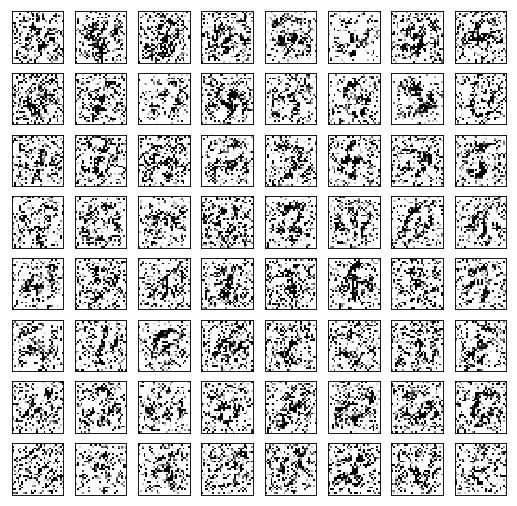

Iteration 231000: loss=0.0008378159254789352
Iteration 232000: loss=0.0008378007332794368
Iteration 233000: loss=0.0008377871126867831
Iteration 234000: loss=0.000837773026432842
Iteration 235000: loss=0.0008377581834793091


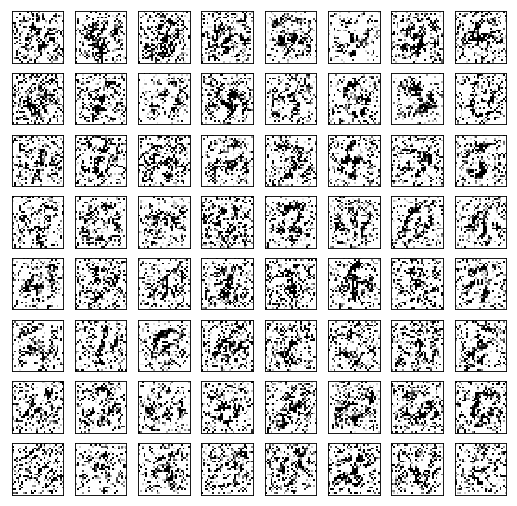

Iteration 236000: loss=0.0008377444464713335
Iteration 237000: loss=0.0008377307094633579
Iteration 238000: loss=0.0008377162157557905
Iteration 239000: loss=0.0008377032936550677
Iteration 240000: loss=0.0008376908372156322


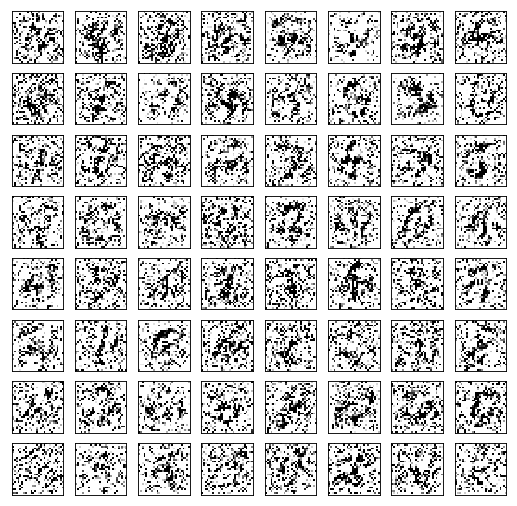

Iteration 241000: loss=0.0008376776822842658
Iteration 242000: loss=0.0008376653422601521
Iteration 243000: loss=0.0008376516634598374
Iteration 244000: loss=0.0008376397308893502
Iteration 245000: loss=0.0008376273326575756


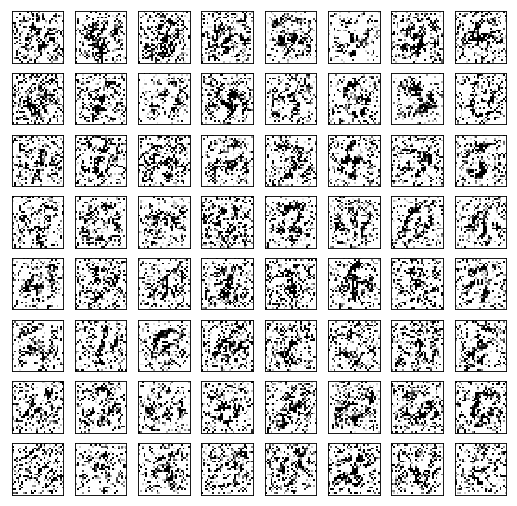

Iteration 246000: loss=0.0008376158075407147
Iteration 247000: loss=0.0008376032346859574
Iteration 248000: loss=0.0008375924080610275
Iteration 249000: loss=0.0008375816978514194
Iteration 250000: loss=0.0008375713368877769


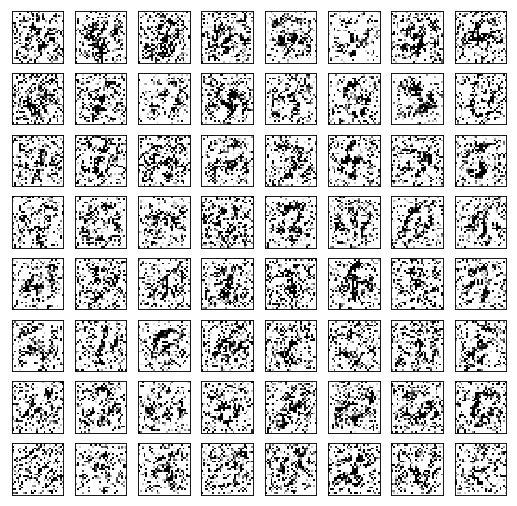

Iteration 251000: loss=0.0008375605684705079
Iteration 252000: loss=0.0008375488687306643
Iteration 253000: loss=0.0008375392062589526
Iteration 254000: loss=0.0008375294273719192
Iteration 255000: loss=0.0008375202305614948


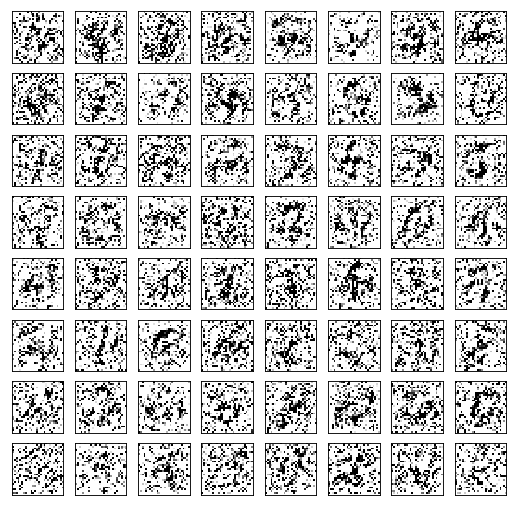

Iteration 256000: loss=0.0008375117904506624
Iteration 257000: loss=0.0008375016623176634
Iteration 258000: loss=0.0008374923490919173
Iteration 259000: loss=0.0008374839671887457
Iteration 260000: loss=0.0008374747703783214


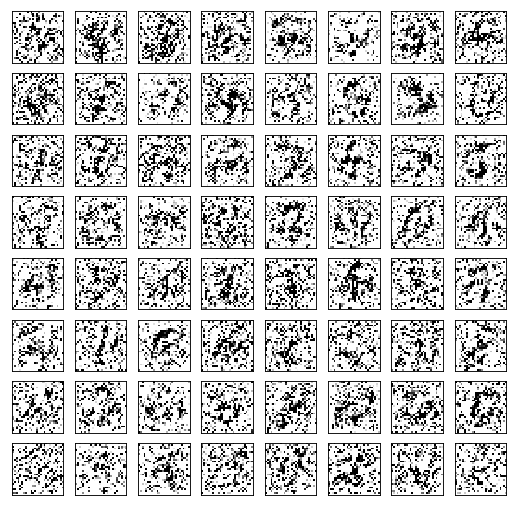

Iteration 261000: loss=0.0008374667377211154
Iteration 262000: loss=0.0008374587050639093
Iteration 263000: loss=0.0008374506724067032
Iteration 264000: loss=0.000837443396449089
Iteration 265000: loss=0.0008374356548301876


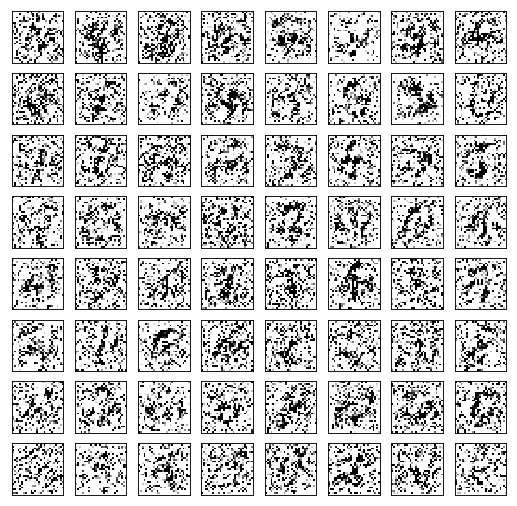

Iteration 266000: loss=0.0008374275057576597
Iteration 267000: loss=0.0008374201715923846
Iteration 268000: loss=0.0008374122553505003
Iteration 269000: loss=0.0008374043391086161
Iteration 270000: loss=0.0008373978780582547


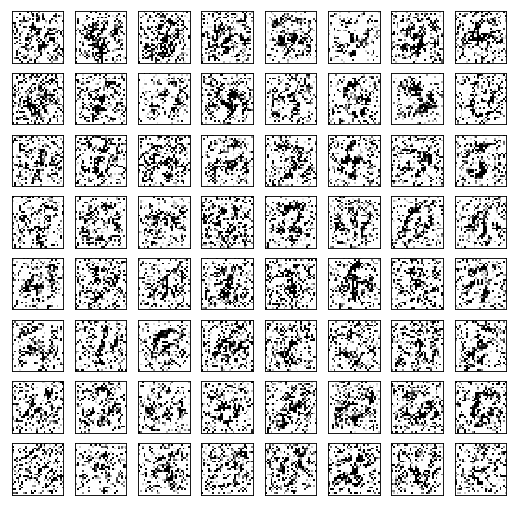

Iteration 271000: loss=0.0008373890304937959
Iteration 272000: loss=0.0008373819873668253
Iteration 273000: loss=0.0008373749442398548
Iteration 274000: loss=0.0008373670279979706
Iteration 275000: loss=0.0008373602177016437


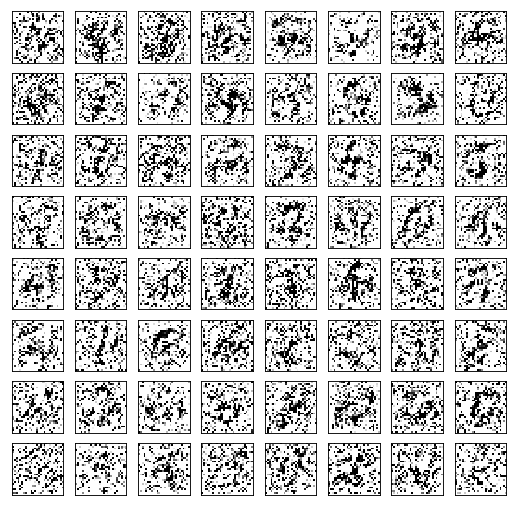

Iteration 276000: loss=0.0008373524178750813
Iteration 277000: loss=0.0008373454911634326
Iteration 278000: loss=0.0008373392047360539
Iteration 279000: loss=0.0008373322780244052
Iteration 280000: loss=0.0008373247110284865


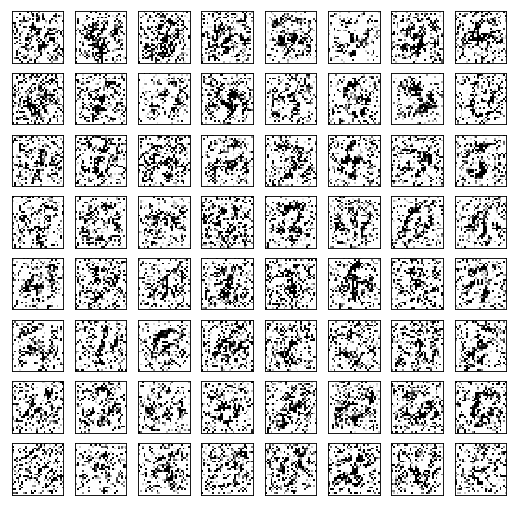

Iteration 281000: loss=0.0008373166201636195
Iteration 282000: loss=0.0008373089367523789
Iteration 283000: loss=0.0008372993324883282
Iteration 284000: loss=0.0008372891461476684
Iteration 285000: loss=0.0008372774464078248


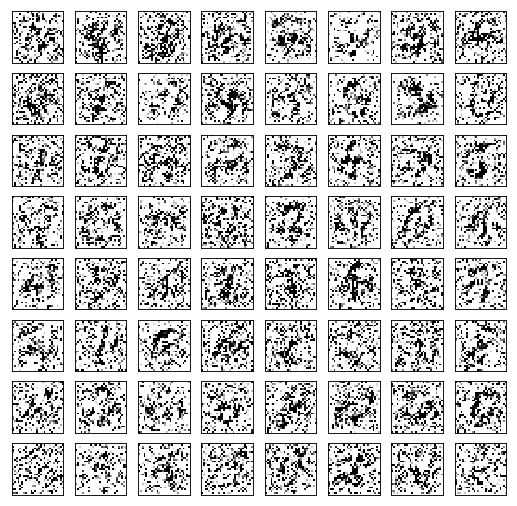

Iteration 286000: loss=0.0008372592274099588
Iteration 287000: loss=0.0008372279116883874
Iteration 288000: loss=0.0008371680160053074
Iteration 289000: loss=0.000837097701150924
Iteration 290000: loss=0.0008370456052944064


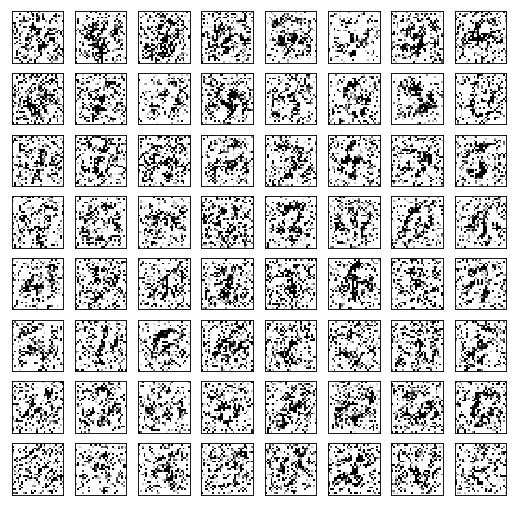

Iteration 291000: loss=0.0008370113209821284
Iteration 292000: loss=0.0008369874558411539
Iteration 293000: loss=0.0008369694696739316
Iteration 294000: loss=0.0008369531133212149
Iteration 295000: loss=0.0008369390852749348


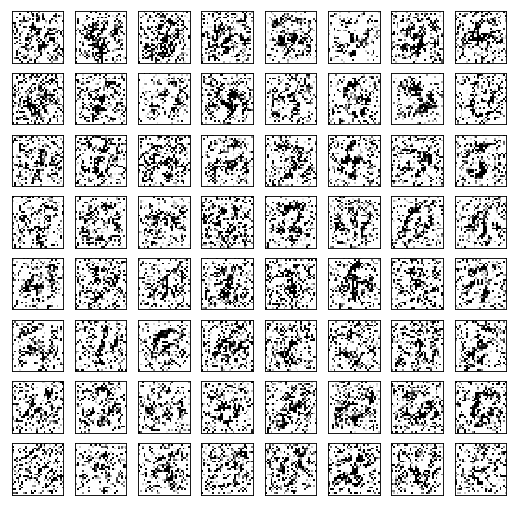

Iteration 296000: loss=0.0008369260467588902
Iteration 297000: loss=0.0008369117276743054
Iteration 298000: loss=0.0008368944399990141
Iteration 299000: loss=0.0008368740673176944
Iteration 300000: loss=0.0008368490380235016


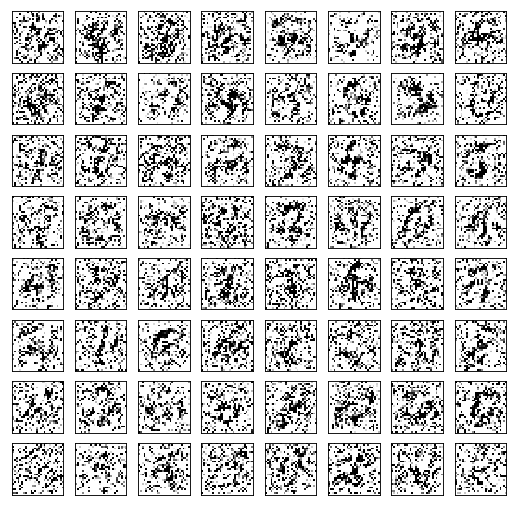

Iteration 301000: loss=0.000836820574477315
Iteration 302000: loss=0.0008367960108444095
Iteration 303000: loss=0.0008367772097699344
Iteration 304000: loss=0.0008367625996470451
Iteration 305000: loss=0.0008367508999072015


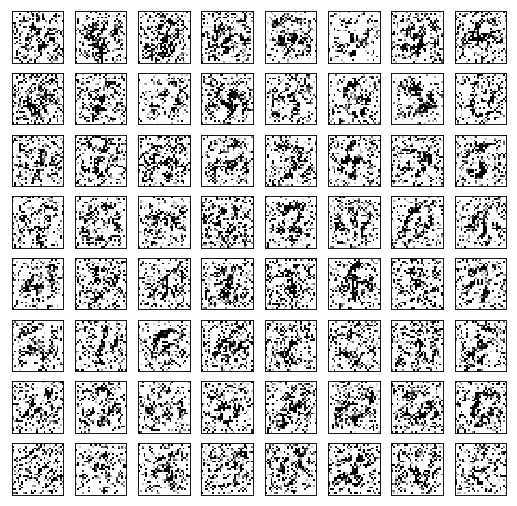

Iteration 306000: loss=0.0008367390255443752
Iteration 307000: loss=0.0008367290138266981
Iteration 308000: loss=0.0008367174305021763
Iteration 309000: loss=0.0008367074187844992
Iteration 310000: loss=0.0008366970578208566


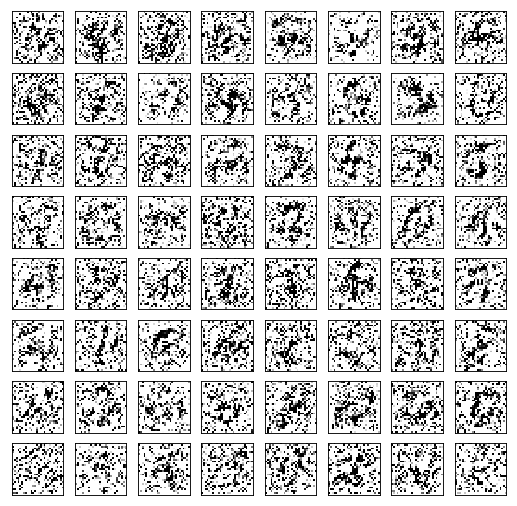

Iteration 311000: loss=0.0008366876281797886
Iteration 312000: loss=0.0008366777328774333
Iteration 313000: loss=0.0008366666152141988
Iteration 314000: loss=0.0008366552065126598
Iteration 315000: loss=0.0008366440306417644


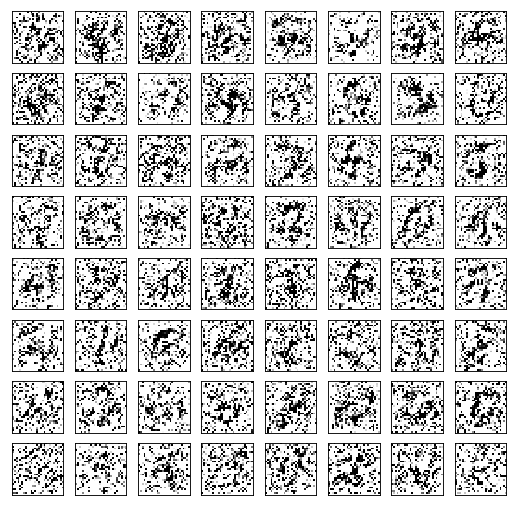

Iteration 316000: loss=0.0008366302354261279
Iteration 317000: loss=0.0008366141701117158
Iteration 318000: loss=0.0008365913527086377
Iteration 319000: loss=0.0008365438552573323
Iteration 320000: loss=0.0008363854140043259


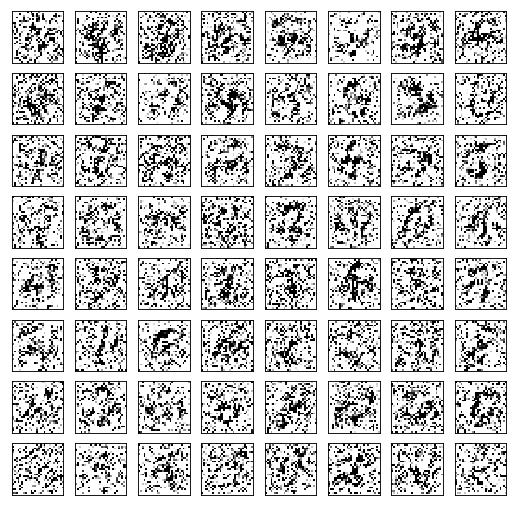

Iteration 321000: loss=0.0008360868087038398
Iteration 322000: loss=0.0008359298226423562
Iteration 323000: loss=0.0008358311606571078
Iteration 324000: loss=0.0008357501355931163
Iteration 325000: loss=0.0008356907055713236


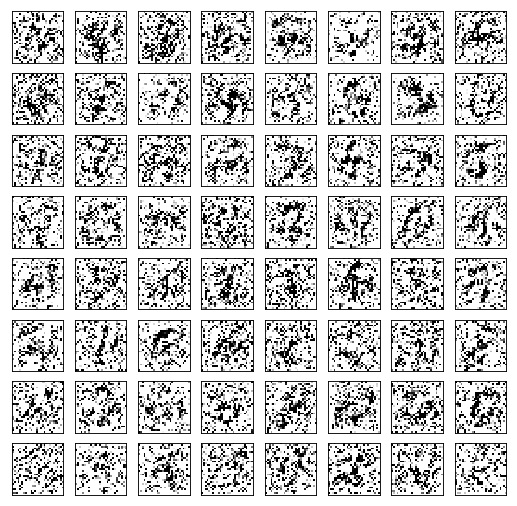

Iteration 326000: loss=0.0008356485632248223
Iteration 327000: loss=0.0008356168982572854
Iteration 328000: loss=0.0008355913450941443
Iteration 329000: loss=0.0008355698082596064
Iteration 330000: loss=0.0008355500758625567


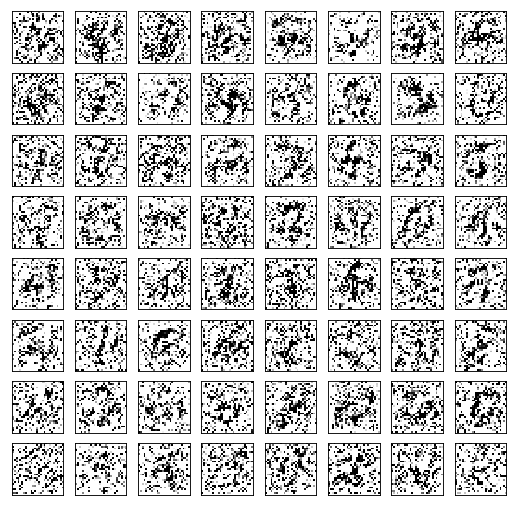

Iteration 331000: loss=0.0008355315658263862
Iteration 332000: loss=0.0008355153840966523
Iteration 333000: loss=0.0008355004247277975
Iteration 334000: loss=0.0008354888414032757
Iteration 335000: loss=0.0008354778401553631


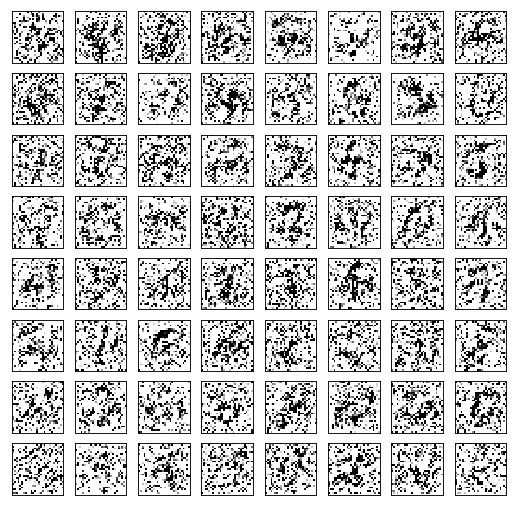

Iteration 336000: loss=0.0008354684105142951
Iteration 337000: loss=0.0008354591554962099
Iteration 338000: loss=0.0008354514138773084
Iteration 339000: loss=0.0008354436722584069
Iteration 340000: loss=0.0008354349411092699


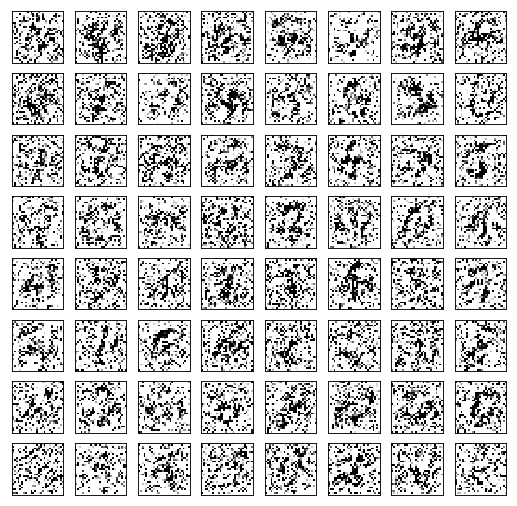

Iteration 341000: loss=0.0008354271994903684
Iteration 342000: loss=0.0008354191086255014
Iteration 343000: loss=0.0008354102028533816
Iteration 344000: loss=0.000835402577649802
Iteration 345000: loss=0.000835393788293004


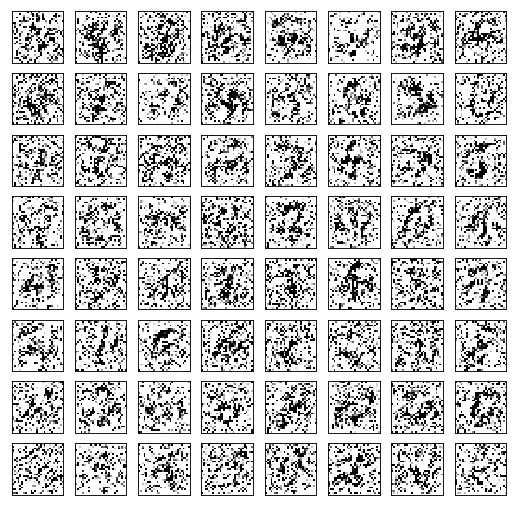

Iteration 346000: loss=0.0008353839511983097
Iteration 347000: loss=0.0008353755692951381
Iteration 348000: loss=0.0008353652083314955
Iteration 349000: loss=0.0008353563025593758
Iteration 350000: loss=0.000835348095279187


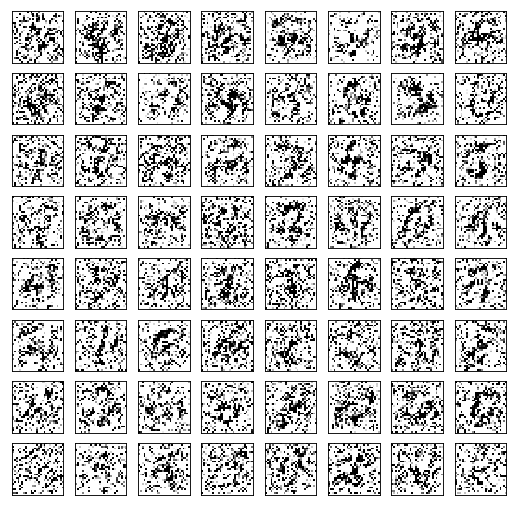

Iteration 351000: loss=0.0008353390730917454
Iteration 352000: loss=0.0008353298180736601
Iteration 353000: loss=0.0008353208540938795
Iteration 354000: loss=0.0008353113080374897
Iteration 355000: loss=0.0008353022858500481


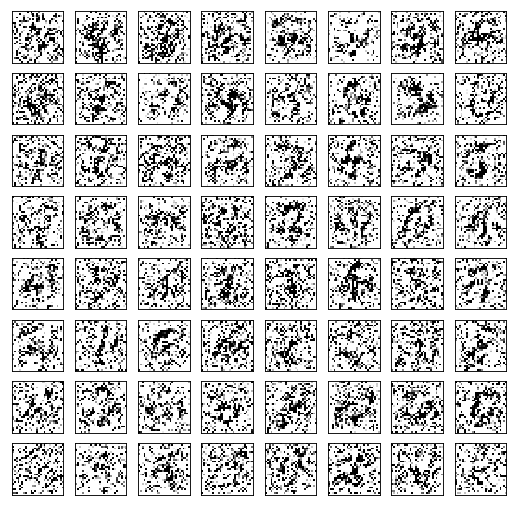

Iteration 356000: loss=0.0008352918666787446
Iteration 357000: loss=0.0008352802833542228
Iteration 358000: loss=0.0008352664299309254
Iteration 359000: loss=0.0008352499571628869
Iteration 360000: loss=0.0008352251024916768


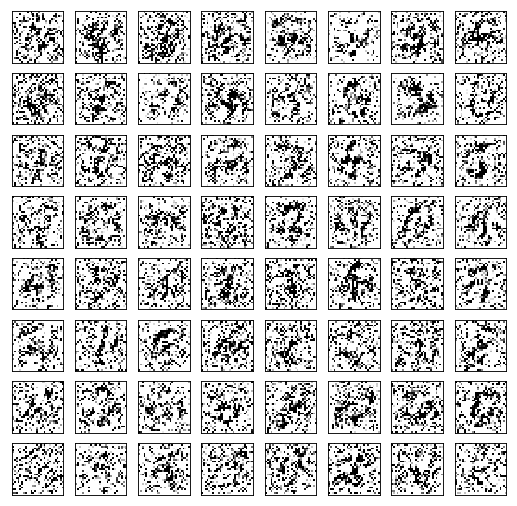

Iteration 361000: loss=0.0008351908763870597
Iteration 362000: loss=0.000835151644423604
Iteration 363000: loss=0.0008351174183189869
Iteration 364000: loss=0.000835089769680053
Iteration 365000: loss=0.0008350683492608368


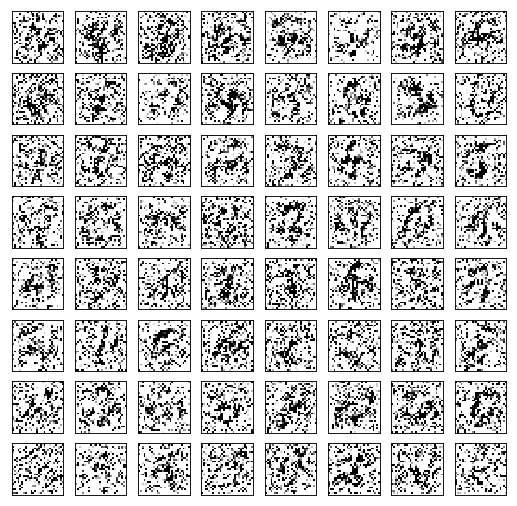

Iteration 366000: loss=0.00083505007205531
Iteration 367000: loss=0.000835032609757036
Iteration 368000: loss=0.0008350152056664228
Iteration 369000: loss=0.0008349964045919478
Iteration 370000: loss=0.0008349778945557773


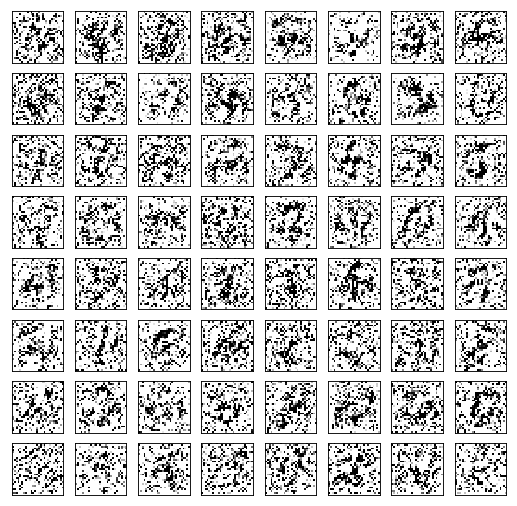

Iteration 371000: loss=0.0008349607232958078
Iteration 372000: loss=0.0008349448326043785
Iteration 373000: loss=0.0008349324343726039
Iteration 374000: loss=0.0008349215495400131
Iteration 375000: loss=0.0008349103736691177


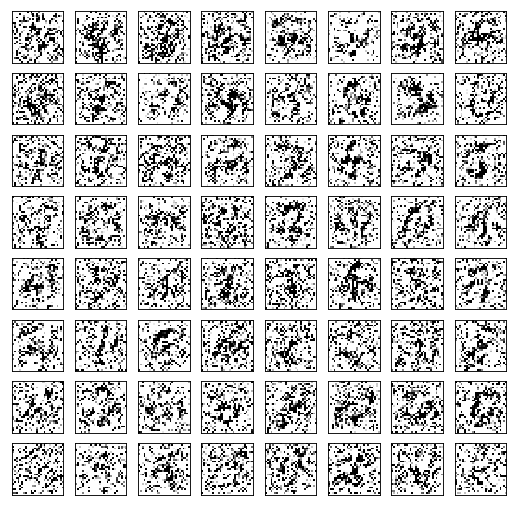

Iteration 376000: loss=0.0008349011186510324
Iteration 377000: loss=0.0008348923875018954
Iteration 378000: loss=0.0008348841802217066
Iteration 379000: loss=0.0008348748087882996
Iteration 380000: loss=0.0008348666597157717


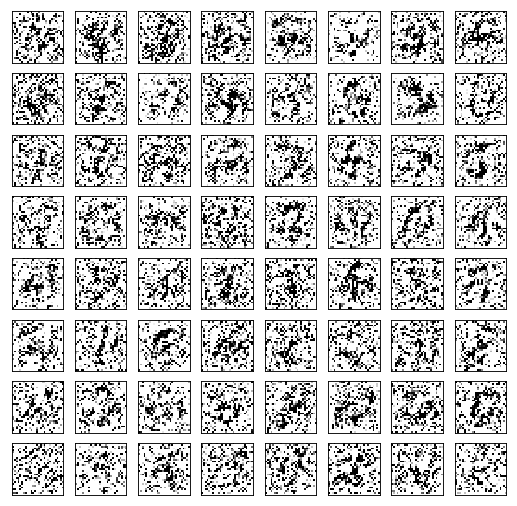

Iteration 381000: loss=0.0008348579867742956
Iteration 382000: loss=0.0008348467526957393
Iteration 383000: loss=0.0008348347619175911
Iteration 384000: loss=0.0008348209667019546
Iteration 385000: loss=0.0008348055416718125


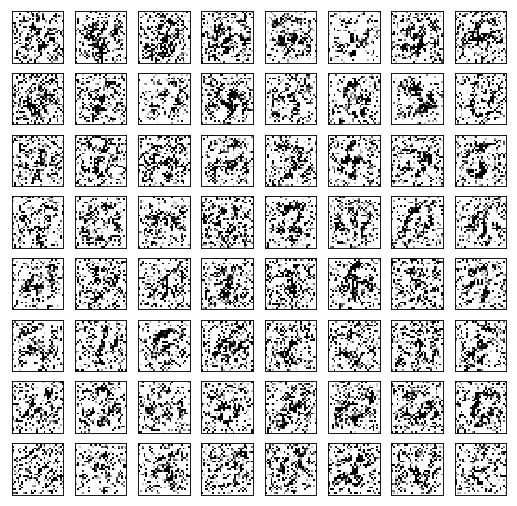

Iteration 386000: loss=0.0008347888942807913
Iteration 387000: loss=0.0008347645052708685
Iteration 388000: loss=0.0008347192197106779
Iteration 389000: loss=0.0008346376707777381
Iteration 390000: loss=0.0008345613605342805


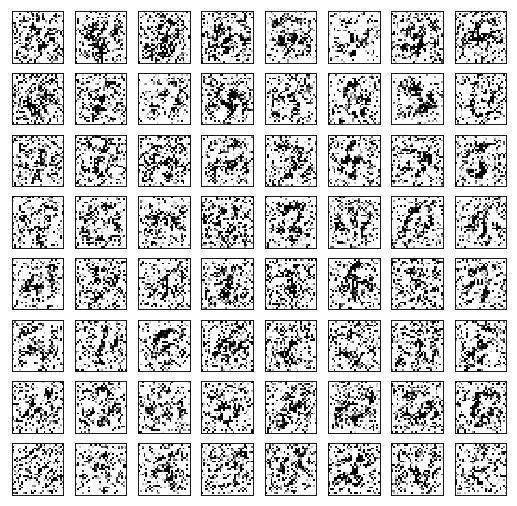

Iteration 391000: loss=0.0008345030364580452
Iteration 392000: loss=0.0008344594389200211
Iteration 393000: loss=0.0008344267844222486
Iteration 394000: loss=0.0008344030939042568
Iteration 395000: loss=0.0008343857480213046


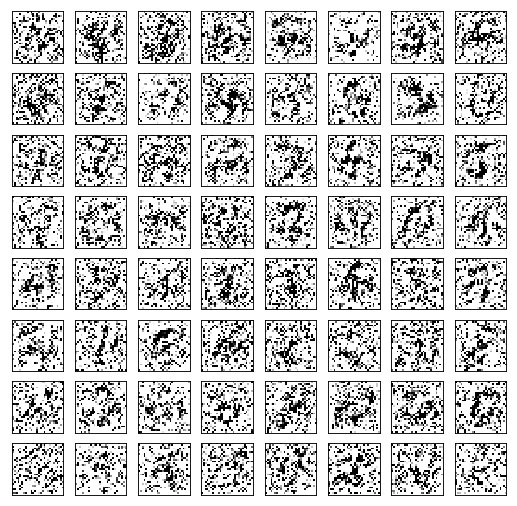

Iteration 396000: loss=0.0008343726512975991
Iteration 397000: loss=0.0008343628142029047
Iteration 398000: loss=0.0008343544322997332
Iteration 399000: loss=0.0008343476220034063
Iteration 400000: loss=0.0008343410445377231


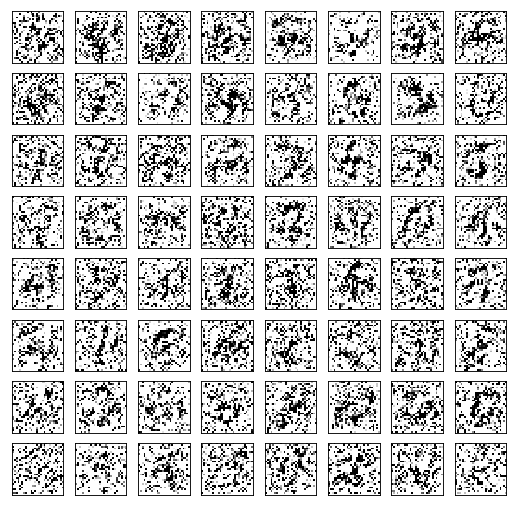

Iteration 401000: loss=0.0008343352237716317
Iteration 402000: loss=0.0008343301014974713
Iteration 403000: loss=0.0008343253284692764
Iteration 404000: loss=0.0008343203226104379
Iteration 405000: loss=0.0008343153167515993


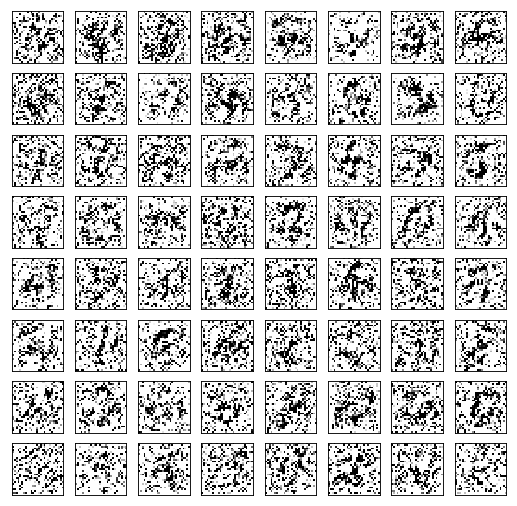

Iteration 406000: loss=0.0008343113586306572
Iteration 407000: loss=0.000834306760225445
Iteration 408000: loss=0.0008343023946508765
Iteration 409000: loss=0.000834298029076308
Iteration 410000: loss=0.0008342932560481131


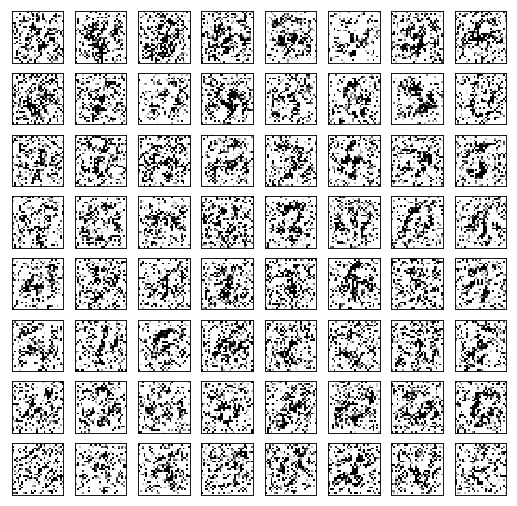

Iteration 411000: loss=0.0008342887740582228
Iteration 412000: loss=0.0008342842920683324
Iteration 413000: loss=0.0008342793444171548
Iteration 414000: loss=0.0008342742221429944
Iteration 415000: loss=0.0008342674118466675


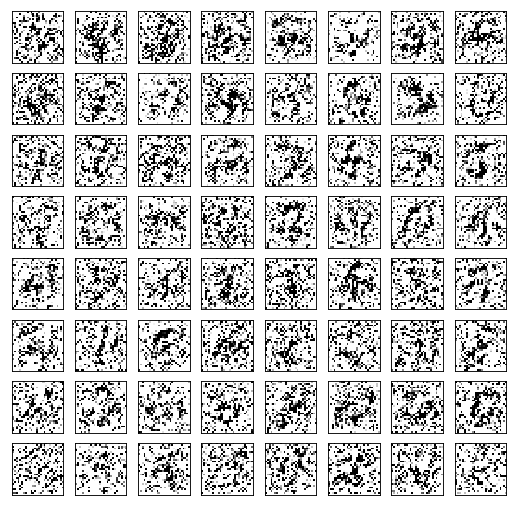

Iteration 416000: loss=0.0008342618821188807
Iteration 417000: loss=0.0008342555374838412
Iteration 418000: loss=0.0008342457585968077
Iteration 419000: loss=0.0008342362707480788
Iteration 420000: loss=0.000834223348647356


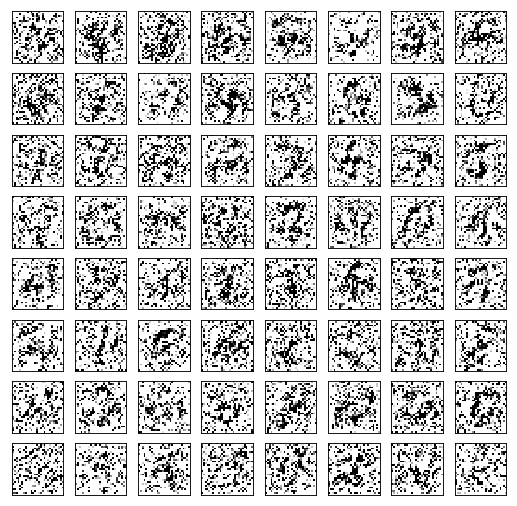

Iteration 421000: loss=0.0008342060027644038
Iteration 422000: loss=0.0008341786451637745
Iteration 423000: loss=0.0008341235807165504
Iteration 424000: loss=0.0008340272470377386
Iteration 425000: loss=0.000833934114780277


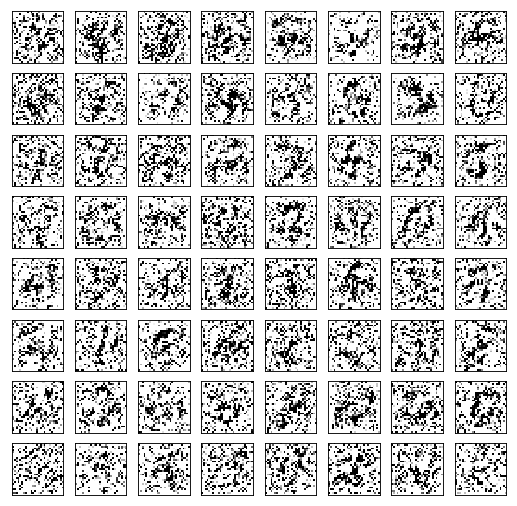

Iteration 426000: loss=0.0008338658954016864
Iteration 427000: loss=0.0008338161860592663
Iteration 428000: loss=0.0008337798644788563
Iteration 429000: loss=0.0008337513427250087
Iteration 430000: loss=0.0008337274193763733


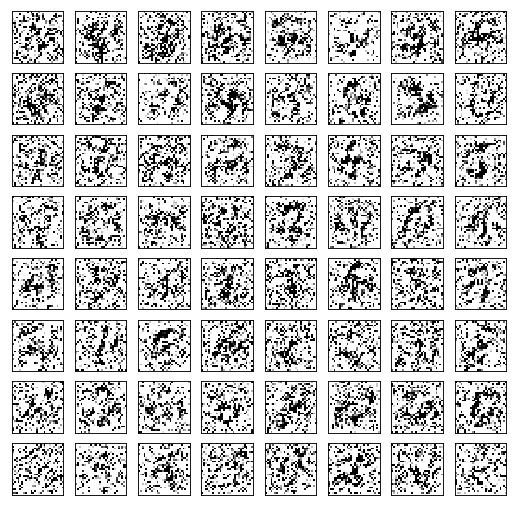

Iteration 431000: loss=0.0008337100152857602
Iteration 432000: loss=0.000833696685731411
Iteration 433000: loss=0.0008336858591064811
Iteration 434000: loss=0.0008336775936186314
Iteration 435000: loss=0.0008336702012456954


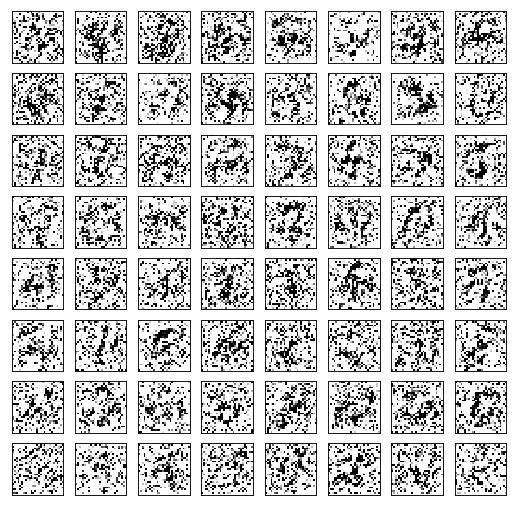

Iteration 436000: loss=0.0008336633327417076
Iteration 437000: loss=0.0008336568134836853
Iteration 438000: loss=0.0008336512837558985
Iteration 439000: loss=0.0008336459286510944
Iteration 440000: loss=0.0008336420869454741


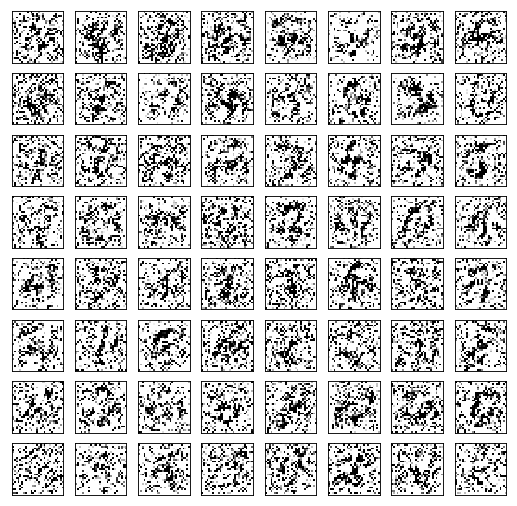

Iteration 441000: loss=0.0008336378377862275
Iteration 442000: loss=0.0008336328319273889
Iteration 443000: loss=0.0008336289320141077
Iteration 444000: loss=0.0008336252067238092


KeyboardInterrupt: 

In [293]:
new_image = generate_image(img)

In [ ]:
to_plot = new_image.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

In [ ]:
print (new_image.shape)
print (new_image)

In [ ]:
latent = model.E(new_image.view(-1, 28*28))
print (latent.shape)
print (latent)

### Генерация изображения из шума

In [ ]:
img = torch.randn(64, 784) 
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

In [ ]:
new_image = generate_image(img)

In [ ]:
to_plot = new_image.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

In [ ]:
print (new_image.shape)
print (new_image)

In [ ]:
latent = model.E(new_image.view(-1, 28*28))
print (latent.shape)
print (latent)

In [ ]:
print (latent_vector)